In [1]:
import pandas as pd
import pymorphy2
import re
import nltk
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import  ward, dendrogram
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.plotting import save
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgapichuzhkina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
russian_stopwords = stopwords.words("russian")
data = pd.read_csv('jaguar.csv')
morph = pymorphy2.MorphAnalyzer()

In [3]:
def parse(text):
    text = re.sub(r'[^\w\s]','',text)
    text = [morph.normal_forms(x)[0] for x in text.split() if x not in russian_stopwords]
    return text

In [4]:
texts = list(data['body'].apply(parse))

In [5]:
len(texts)

50

In [6]:
w2v = Word2Vec(texts, size=300, window=5, min_count=5, iter=10)
w2v.init_sims(replace = True)
w2v.save("jaguar_word2vec.model")

In [7]:
cnt = Counter()
for text in texts:
    cnt.update(text)

In [8]:
len(cnt)

3935

In [9]:
terms = [i[0] for i in cnt.most_common(500)]
#так как всего в текстах 3935 уникальных слов, выбираем самые частотные 500
terms_vec = w2v[terms]
tsne = TSNE(n_components=2, random_state=0)
terms_tsne = tsne.fit_transform(terms_vec)
output_notebook()
source = ColumnDataSource(data=dict(x1=terms_tsne[:,0],
                                    x2=terms_tsne[:,1],
                                    labels = terms))
hover = HoverTool(tooltips = [("label","@labels")])
p = figure(title="TSNE for terms", tools = [hover])
p.scatter(x="x1", y="x2", size=3, source=source)
output_file('w2v_visualization.html', mode = "inline")
save(p)

Loading BokehJS ...

'/Users/olgapichuzhkina/Documents/w2v_visualization.html'

/Users/olgapichuzhkina/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


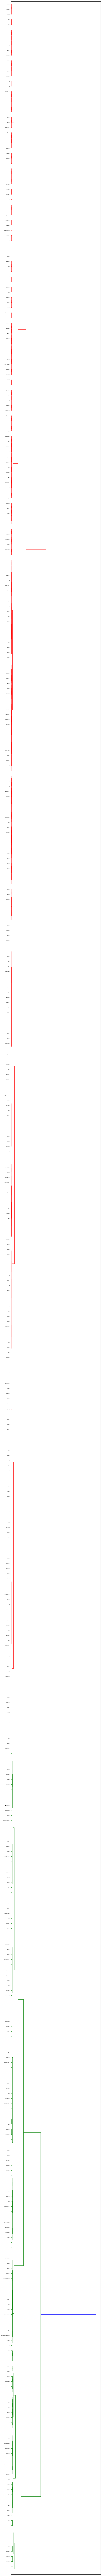

In [10]:
dist = 1 - cosine_similarity(terms_vec)
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(10, 250)) 
ax = dendrogram(linkage_matrix, orientation="right", labels=terms);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() 

plt.savefig('w2v_clusters.png', dpi=200) #save figure as ward_clusters

In [11]:
tagged_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
doc2v = Doc2Vec(tagged_documents, size=300, window=5, min_count=5, iter=10)
doc2v.init_sims(replace = True)
doc2v.save("jaguar_doc2vec.model")